In [2]:
import pandas as pd


In [3]:
df = pd.read_csv('../data/cc-transactions-project.csv')
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   record_number          1296675 non-null  int64  
 1   transaction_date_time  1296675 non-null  object 
 2   cc_number              1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amount                 1296675 non-null  float64
 6   first_name             1296675 non-null  object 
 7   last_name              1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [46]:
temp = pd.read_csv('../data/cc-transactions-project.csv')
temp['merchant'].value_counts()
temp['category'].value_counts()
temp['job'].value_counts()
temp['cc_number'].value_counts()

cc_number
4512828414983801773    3123
571365235126           3123
36722699017270         3119
213112402583773        3117
3545109339866548       3113
                       ... 
180097223252063           7
340187018810220           7
501894933032              7
4975457191020             7
3545578418030657          7
Name: count, Length: 983, dtype: int64

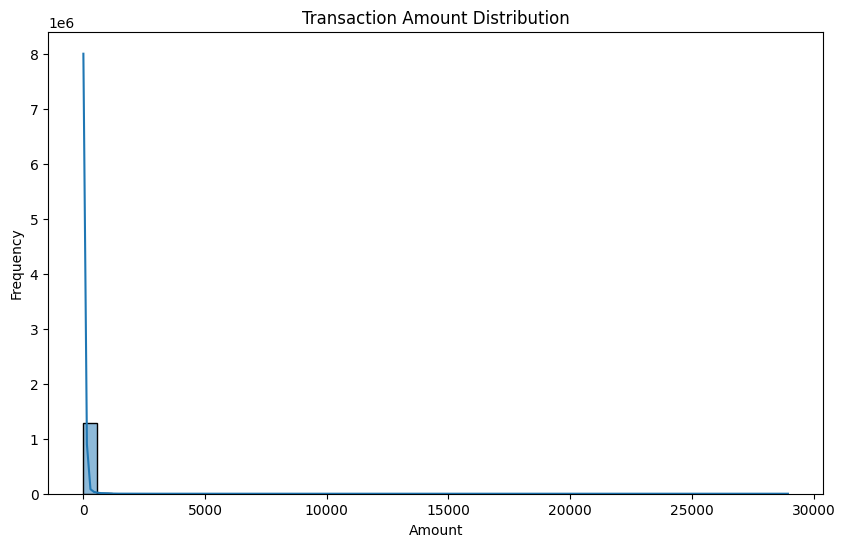

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

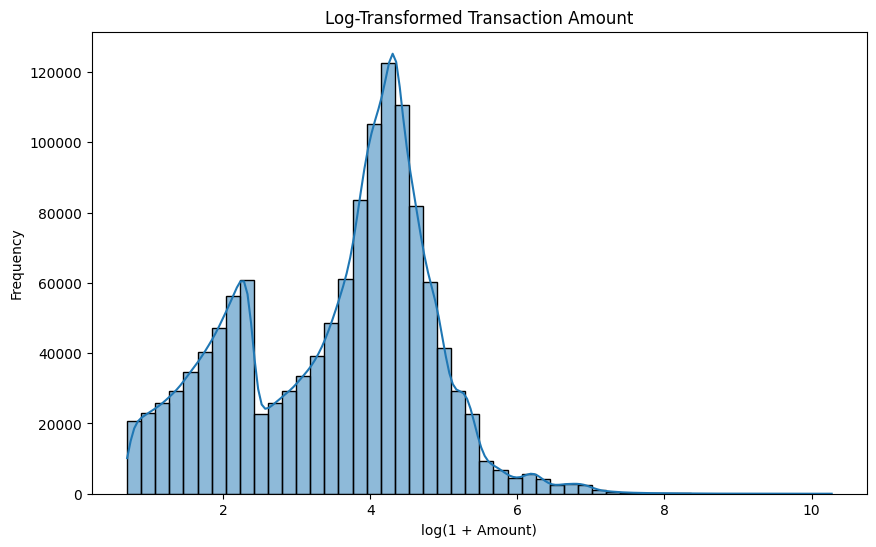

In [6]:
import numpy as np

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['amount']), bins=50, kde=True)
plt.title('Log-Transformed Transaction Amount')
plt.xlabel('log(1 + Amount)')
plt.ylabel('Frequency')
plt.show()

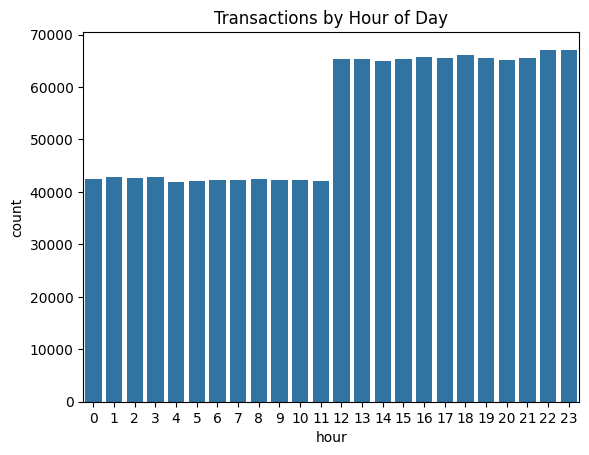

In [7]:
df['transaction_date_time'] = pd.to_datetime(df['transaction_date_time'])
df['hour'] = df['transaction_date_time'].dt.hour
df['day'] = df['transaction_date_time'].dt.day
df['weekday'] = df['transaction_date_time'].dt.weekday

# Transactions by hour
sns.countplot(x='hour', data=df)
plt.title('Transactions by Hour of Day')
plt.show()

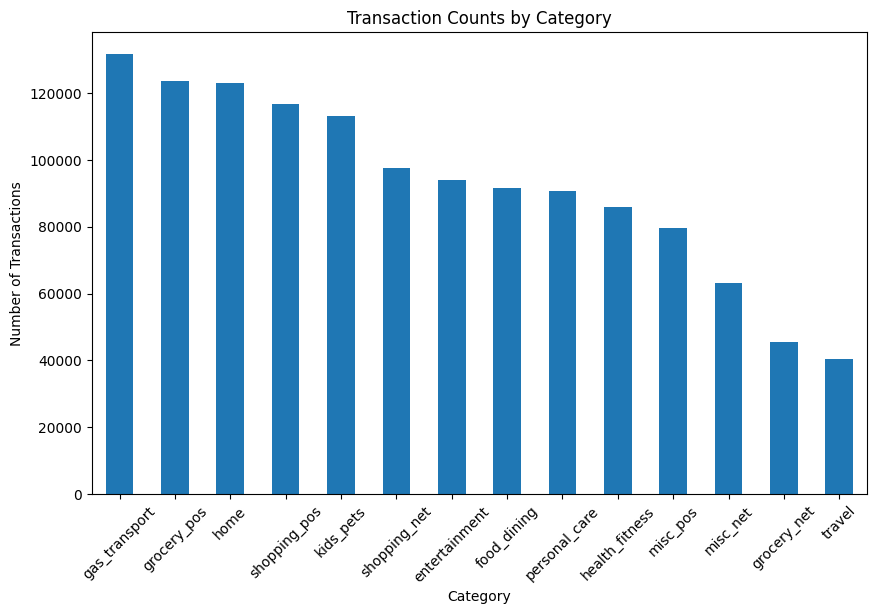

In [8]:
plt.figure(figsize=(10, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Transaction Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

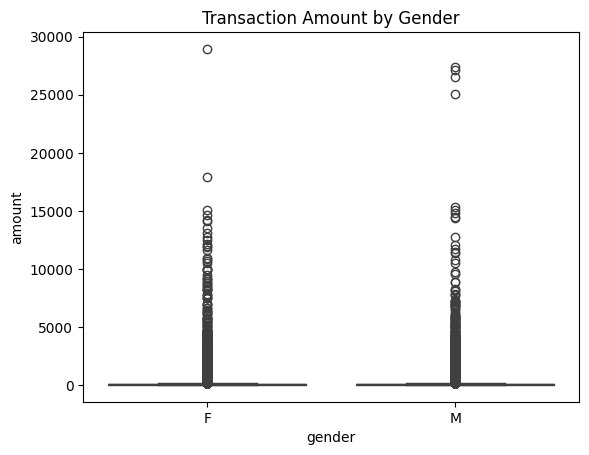

In [9]:
sns.boxplot(x='gender', y='amount', data=df)
plt.title('Transaction Amount by Gender')
plt.show()

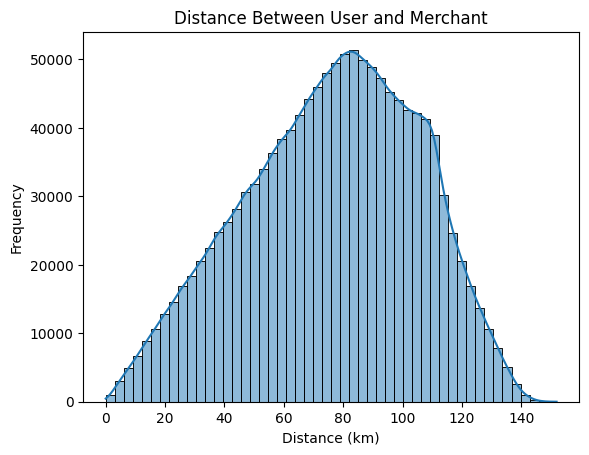

In [10]:
# Distance between user and merchant (quick haversine approximation)
from geopy.distance import geodesic

df['user_loc'] = list(zip(df['lat'], df['long']))
df['merchant_loc'] = list(zip(df['merch_lat'], df['merch_long']))

df['distance_km'] = df.apply(lambda row: geodesic(row['user_loc'], row['merchant_loc']).km, axis=1)

sns.histplot(df['distance_km'], bins=50, kde=True)
plt.title('Distance Between User and Merchant')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

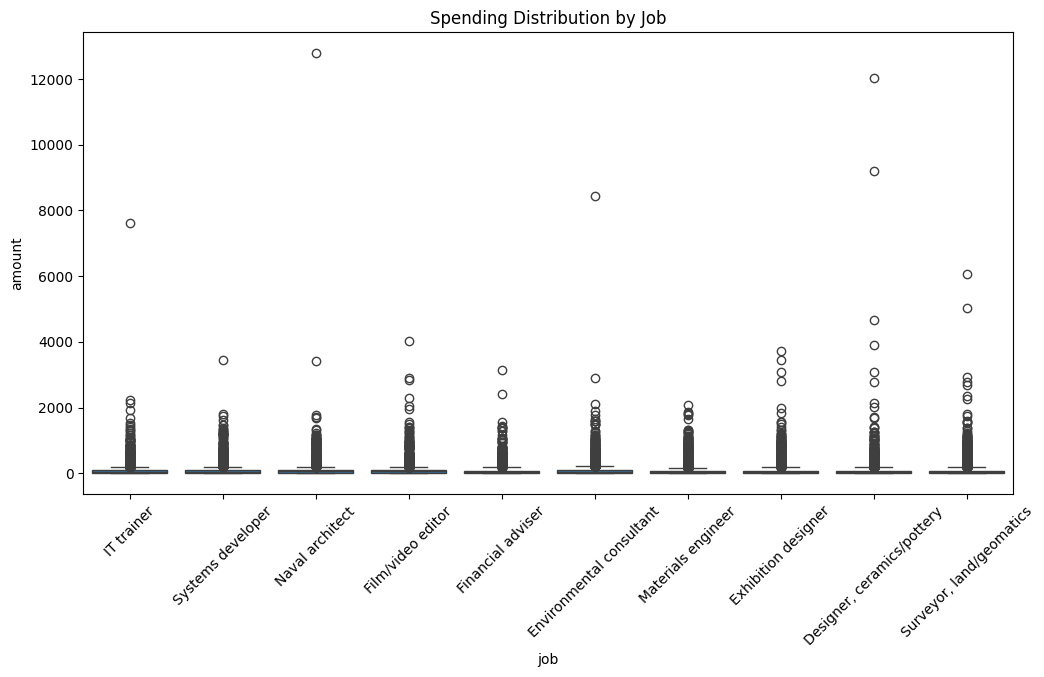

In [11]:
top_jobs = df['job'].value_counts().head(10).index
df_top_jobs = df[df['job'].isin(top_jobs)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='job', y='amount', data=df_top_jobs)
plt.xticks(rotation=45)
plt.title('Spending Distribution by Job')
plt.show()

In [12]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    print("Columns with missing values:")
    print(missing)
    plt.figure(figsize=(10, 5))
    missing.plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found.")


No missing values found.


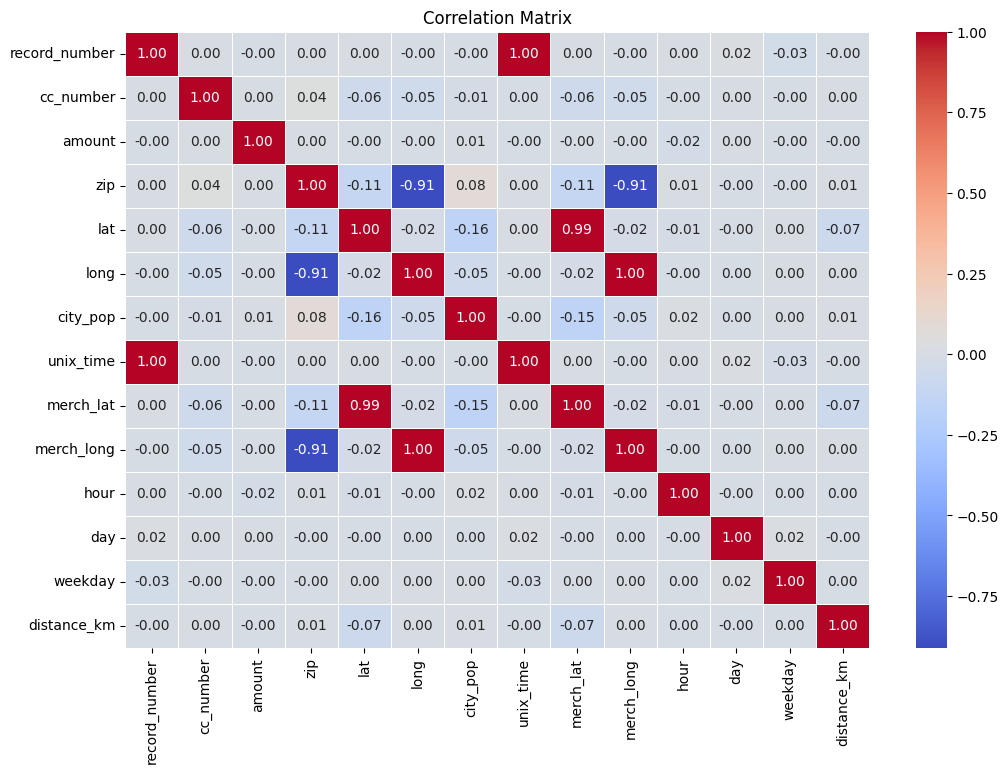

In [13]:
import seaborn as sns

# Keep only numerical columns
num_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr = num_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


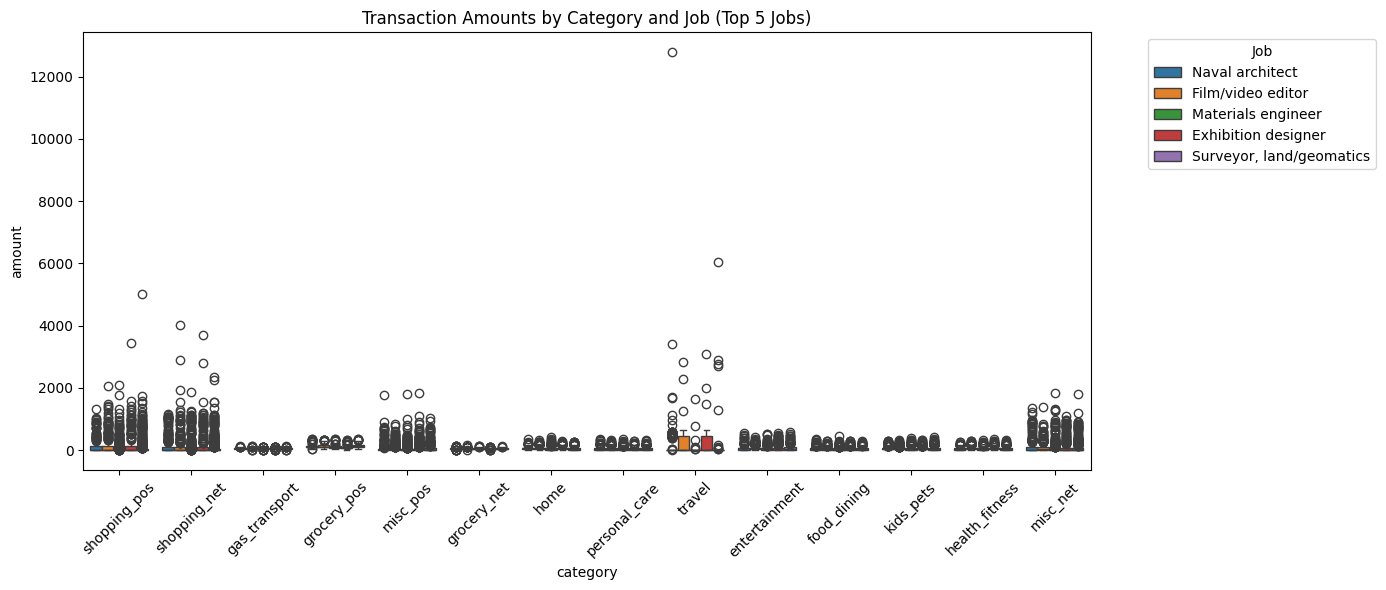

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 5 most common jobs
top_jobs = df['job'].value_counts().head(5).index
filtered_df = df[df['job'].isin(top_jobs)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_df, x='category', y='amount', hue='job')
plt.title('Transaction Amounts by Category and Job (Top 5 Jobs)')
plt.xticks(rotation=45)
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

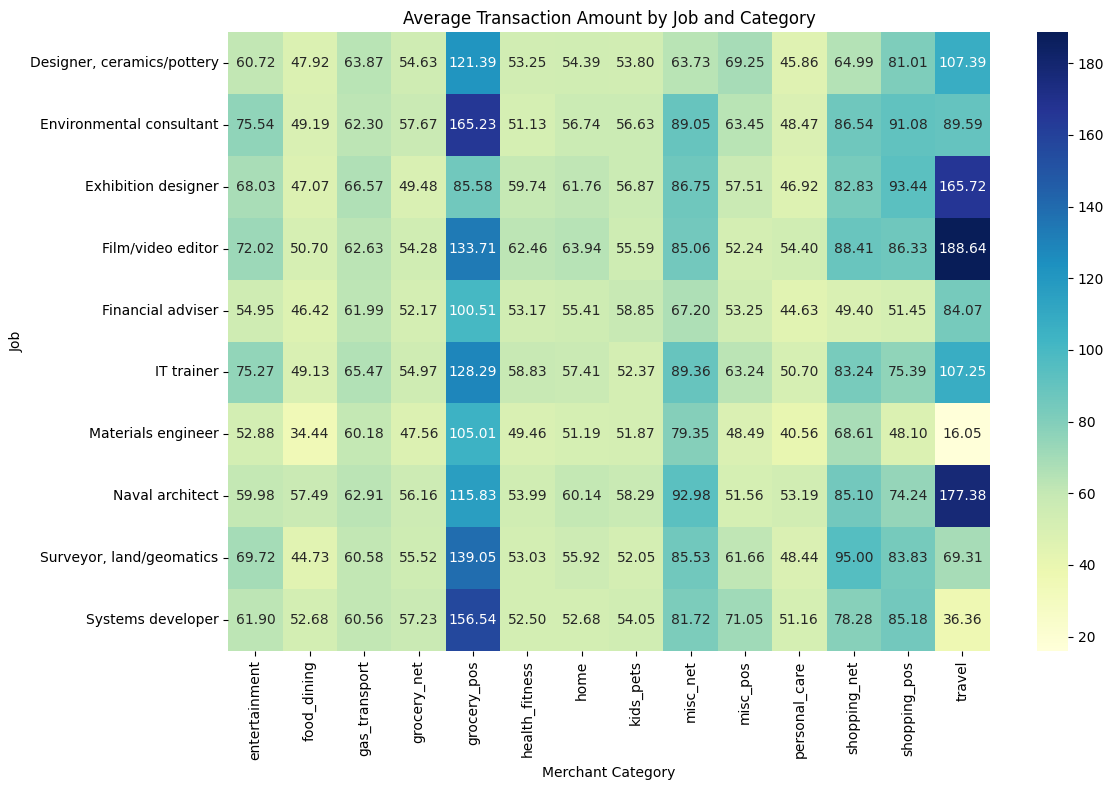

In [15]:
# Again limit jobs to top N for visibility
top_jobs = df['job'].value_counts().head(10).index
filtered_df = df[df['job'].isin(top_jobs)]

# Create pivot table
pivot = filtered_df.pivot_table(index='job', columns='category', values='amount', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average Transaction Amount by Job and Category')
plt.ylabel('Job')
plt.xlabel('Merchant Category')
plt.tight_layout()
plt.show()

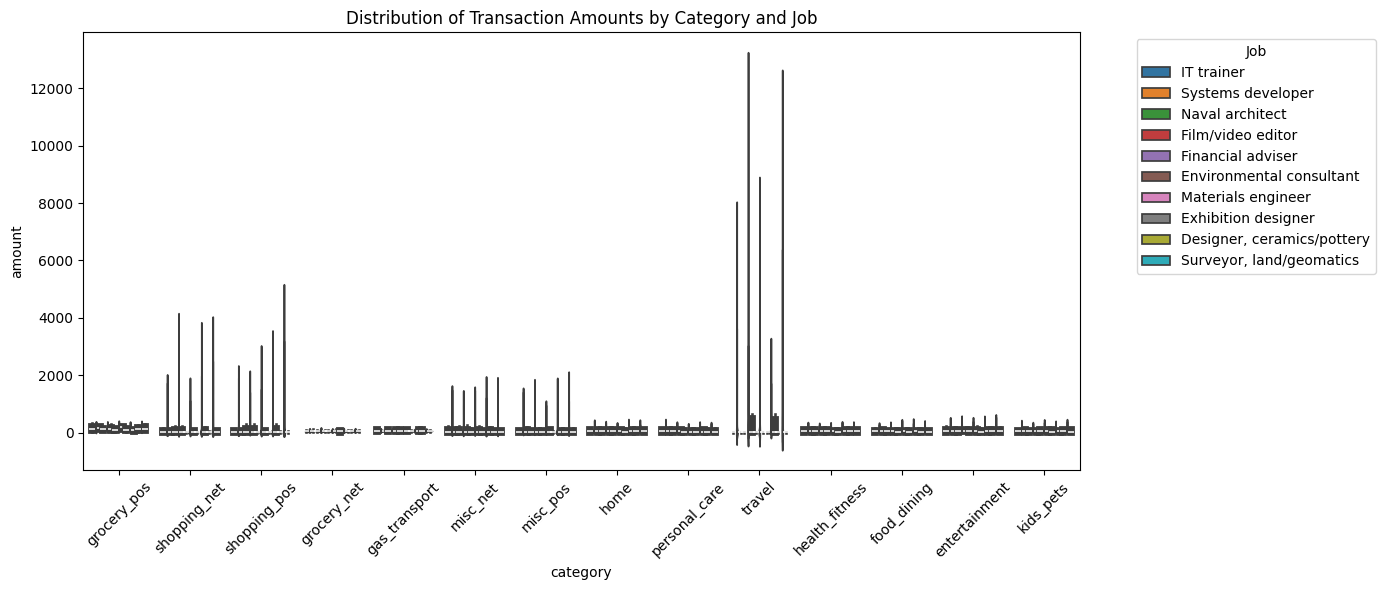

In [16]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=filtered_df, x='category', y='amount', hue='job', split=True)
plt.title('Distribution of Transaction Amounts by Category and Job')
plt.xticks(rotation=45)
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
# Group by job and category
job_cat_stats = df.groupby(['job', 'category'])['amount'].agg(['mean', 'std']).reset_index()

# Sort by mean amount (descending) for readability
job_cat_stats = job_cat_stats.sort_values(by='mean', ascending=False)

# Round for cleaner display
job_cat_stats['mean'] = job_cat_stats['mean'].round(2)
job_cat_stats['std'] = job_cat_stats['std'].round(2)

print(job_cat_stats.head(100))  # View top 10 rows

                        job      category     mean      std
5767            Ship broker  shopping_pos  1313.18      NaN
3638        Legal secretary  shopping_net  1115.50      NaN
1590                 Dancer  shopping_net  1066.05   140.73
18    Accountant, chartered  shopping_net  1063.77      NaN
3104              Homeopath  shopping_pos  1050.27      NaN
...                     ...           ...      ...      ...
707     Broadcast presenter        travel   322.05   248.57
3245            Hydrologist        travel   318.28  1898.74
5823         Soil scientist        travel   317.04   307.80
3101              Homeopath   grocery_pos   315.05    13.65
15    Accountant, chartered   grocery_pos   313.95     7.26

[100 rows x 4 columns]


/tmp/ipykernel_72775/3876027488.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


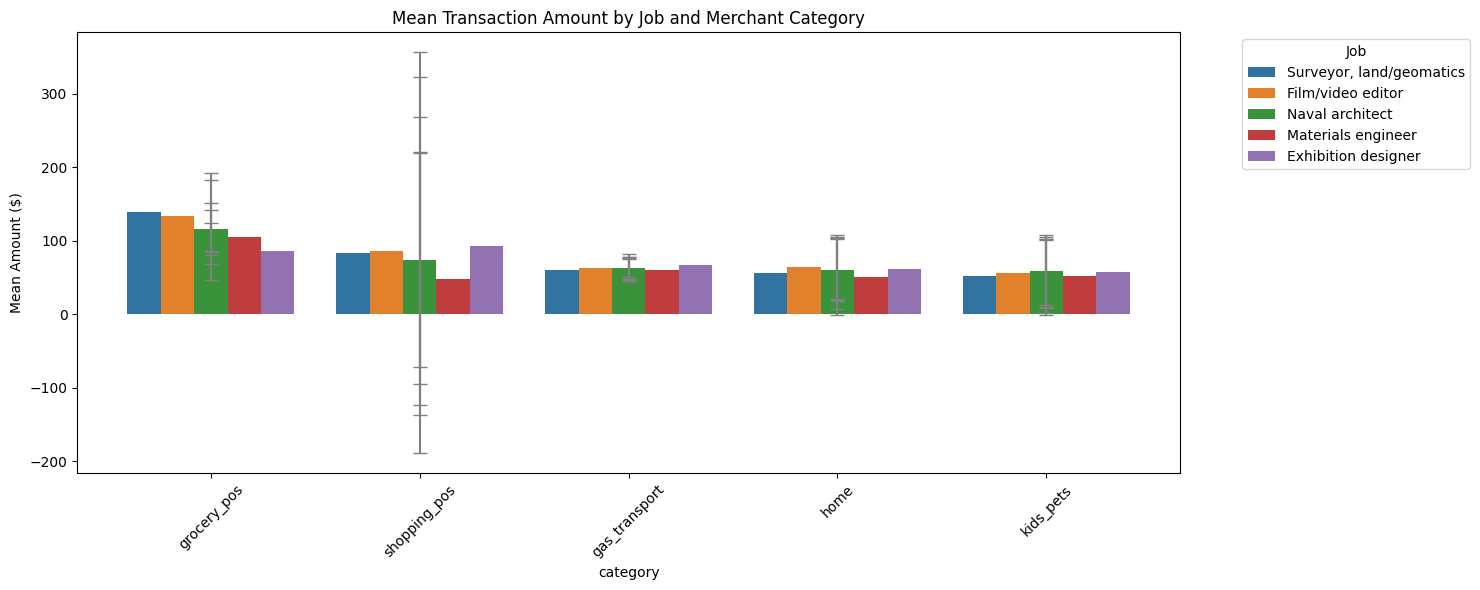

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Limit to top N most common jobs/categories to avoid clutter
top_jobs = df['job'].value_counts().head(5).index
top_cats = df['category'].value_counts().head(5).index

filtered_stats = job_cat_stats[
    job_cat_stats['job'].isin(top_jobs) & job_cat_stats['category'].isin(top_cats)
]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_stats,
    x='category', y='mean', hue='job',
    ci=None, capsize=0.1
)

# Add std as error bars
for i, row in filtered_stats.iterrows():
    plt.errorbar(
        x=row['category'],
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        ecolor='gray',
        capsize=5
    )

plt.title('Mean Transaction Amount by Job and Merchant Category')
plt.ylabel('Mean Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Job', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [19]:
df['transaction_date_time'] = pd.to_datetime(df['transaction_date_time'])

# Sort by credit card and time
df_sorted = df.sort_values(by=['cc_number', 'transaction_date_time'])
df_sorted['time_since_last_txn'] = df_sorted.groupby('cc_number')['transaction_date_time'].diff().dt.total_seconds()


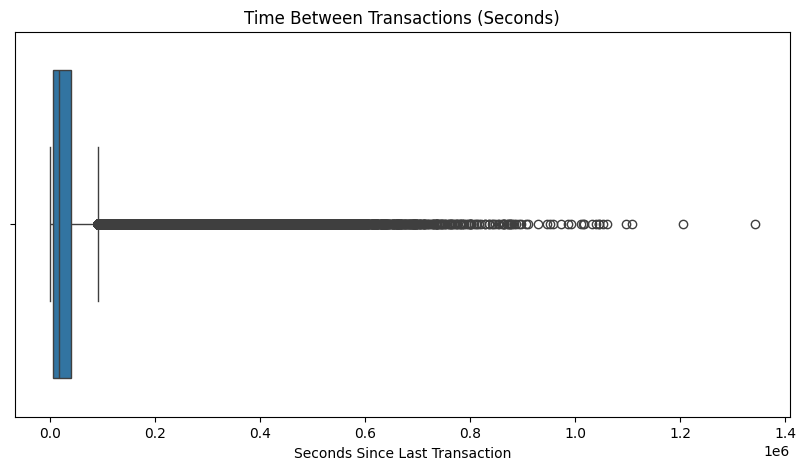

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_sorted['time_since_last_txn'].dropna())
plt.title('Time Between Transactions (Seconds)')
plt.xlabel('Seconds Since Last Transaction')
plt.show()


In [21]:
rapid_txns = df_sorted[df_sorted['time_since_last_txn'] < 30]

print(f"! Found {len(rapid_txns)} suspiciously fast transactions (within 30 seconds of previous).")
display(rapid_txns[['cc_number', 'transaction_date_time', 'time_since_last_txn', 'amount', 'merchant', 'category']].head(10))


! Found 1984 suspiciously fast transactions (within 30 seconds of previous).


,cc_number,transaction_date_time,time_since_last_txn,amount,merchant,category
106628,60416207185,2019-03-02 22:10:59,21.0,261.79,"fraud_Windler, Goodwin and Kovacek",home
783205,60416207185,2019-11-30 21:52:18,2.0,36.14,"fraud_Cole, Hills and Jewess",home
1208243,60416207185,2020-05-19 20:04:01,20.0,109.79,"fraud_Walter, Hettinger and Kessler",personal_care
110514,60422928733,2019-03-04 05:08:06,29.0,46.81,fraud_O'Keefe-Hudson,grocery_pos
707572,60487002085,2019-10-28 19:15:14,2.0,12.17,fraud_Kozey-Kuhlman,personal_care
818563,60495593109,2019-12-08 14:39:05,21.0,12.45,fraud_Parker-Kunde,personal_care
286772,501802953619,2019-05-20 21:57:35,24.0,21.34,"fraud_Pouros, Walker and Spencer",kids_pets
793471,501802953619,2019-12-02 15:09:04,15.0,146.87,fraud_Bednar PLC,kids_pets
820466,501802953619,2019-12-08 20:33:05,4.0,92.97,fraud_Gaylord-Powlowski,home
1250364,501802953619,2020-06-04 19:23:42,27.0,46.75,fraud_Wilkinson PLC,kids_pets


In [51]:
card_agg = rapid_txns.groupby('cc_number').size().sort_values(ascending=False)
print("Top cards with rapid purchases:")
print(card_agg.head(10))
print(f'Count of rapid card purchases: {card_agg.shape[0]}')

Top cards with rapid purchases:
cc_number
4364010865167176    19
4586810168620942    16
2283743876903625    14
3575789281659026    14
3545109339866548    14
6011109736646996    13
3560797065840735    13
3521417320836166    12
3553629419254918    11
3576021480694169    11
dtype: int64
Count of rapid card purchases: 611


In [35]:
from timezonefinder import TimezoneFinder
import pytz

# Create timezone finder object
tf = TimezoneFinder()

def convert_to_local(row):
    try:
        tz_str = tf.timezone_at(lat=row['lat'], lng=row['long'])
        if tz_str:
            tz = pytz.timezone(tz_str)
            # Assumes transaction_date_time is in UTC
            return row['transaction_date_time'].astimezone(tz)
    except Exception as e:
        print(f"Error at row {row.name}: {e}")
    return pd.NaT

df['transaction_date_time'] = pd.to_datetime(df['transaction_date_time'], utc=True)
df['local_time'] = df.apply(convert_to_local, axis=1)
#df['local_hour'] = df['local_time'].dt.hour
df['local_hour'] = [t.hour for t in df['local_time']]



In [36]:
def label_time_period(hour):
    if 0 <= hour < 5:
        return 'asleep'
    elif 9 <= hour < 17:
        return 'work_hours'
    else:
        return 'off_hours'

df['time_period'] = df['local_hour'].apply(label_time_period)

In [49]:
suspicious_txns = df[df['time_period'].isin(['asleep'])]

print(f"! Found {len(suspicious_txns)} transactions during sleep hours.")
display(suspicious_txns[['cc_number', 'local_time', 'time_period', 'amount', 'merchant', 'city', 'job']].sort_values(by='amount', ascending=False))

! Found 211995 transactions during sleep hours.


,cc_number,local_time,time_period,amount,merchant,city,job
42665,371034293500716,2019-01-26 04:52:07-08:00,asleep,5234.79,"fraud_Schroeder, Wolff and Hermiston",Vinton,Education administrator
743710,4440581794652,2019-11-14 02:32:31-08:00,asleep,3944.28,fraud_Conroy Ltd,San Diego,"Pharmacist, hospital"
341669,379897244598068,2019-06-10 02:06:11-04:00,asleep,3856.42,"fraud_Watsica, Haag and Considine",Pewee Valley,Stage manager
1131787,377834944388609,2020-04-16 04:32:29-05:00,asleep,3777.63,fraud_Pouros-Haag,Pea Ridge,Product designer
273289,6554245334757802,2019-05-15 00:44:25-07:00,asleep,3773.30,"fraud_Daugherty, Pouros and Beahan",Laguna Hills,Sales executive
...,...,...,...,...,...,...,...
1280050,3551512895305309,2020-06-15 04:49:35-05:00,asleep,1.00,"fraud_Towne, Greenholt and Koepp",Rochester,"Development worker, international aid"
686693,343668971234893,2019-10-20 02:28:37-04:00,asleep,1.00,fraud_Terry-Huel,Hopkins,Chiropodist
349166,375904527651269,2019-06-13 00:57:24-05:00,asleep,1.00,"fraud_Quitzon, Green and Bashirian",Roseland,"Nurse, mental health"
208352,4708992452821239,2019-04-16 01:03:29-05:00,asleep,1.00,fraud_Hills-Witting,Cord,"Designer, ceramics/pottery"


In [54]:
from datetime import datetime

# Step 1: Make sure DOB is parsed correctly
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Step 2: Calculate age more robustly
df['age_at_transaction'] = df.apply(
    lambda row: row['transaction_date_time'].year - row['dob'].year 
    - ((row['transaction_date_time'].month, row['transaction_date_time'].day) < 
       (row['dob'].month, row['dob'].day)), axis=1)

# Define age thresholds
too_young = df['age_at_transaction'] < 18
too_old = df['age_at_transaction'] > 100

suspicious_age_df = df[(df['age_at_transaction'] < 18) | (df['age_at_transaction'] > 100)]


# Show results
display(suspicious_age_df[['first_name', 'last_name', 'dob', 'age_at_transaction', 'transaction_date_time']].sort_values(by='age_at_transaction', ascending=True))



,first_name,last_name,dob,age_at_transaction,transaction_date_time
1297,Michael,Gross,2005-01-29,13,2019-01-01 15:02:07+00:00
5958,Michael,Gross,2005-01-29,13,2019-01-04 20:21:10+00:00
46842,Michael,Gross,2005-01-29,13,2019-01-28 15:41:11+00:00
47000,Michael,Gross,2005-01-29,13,2019-01-28 17:01:13+00:00
47168,Michael,Gross,2005-01-29,13,2019-01-28 18:20:13+00:00
...,...,...,...,...,...
673069,Melvin,Wright,2001-12-19,17,2019-10-13 22:19:20+00:00
674883,Melvin,Wright,2001-12-19,17,2019-10-14 13:44:05+00:00
683576,Melvin,Wright,2001-12-19,17,2019-10-19 02:13:20+00:00
681852,Melvin,Wright,2001-12-19,17,2019-10-18 05:42:38+00:00
